In [15]:
import numpy as np
import tensorflow as tf
from curriculum_learning.models.classifier_model import ClassifierModel
from curriculum_learning import utils
import yaml
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [19]:
N_EPOCHS = 50
N_TRIALS = 3
BATCH_SIZE = 256

loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [21]:
with open("models_hyperparameters.yaml", "r") as stream:
    models_hyperparameters = yaml.safe_load(stream)
    
x, y = utils.load_data("../data/cifar-10-batches-py/data_batch_1")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

train_size = x_train.shape[0]

In [22]:
noise = 30
x_train = np.clip(x_train + np.random.normal(0, noise, x_train.shape), 0, 255) / 255
x_val = np.clip(x_val + np.random.normal(0, noise, x_val.shape), 0, 255) / 255
x_test = np.clip(x_test + np.random.normal(0, noise, x_test.shape), 0, 255) / 255

In [ ]:
assessment_model = ClassifierModel(output_shape=10, **models_hyperparameters["assessment_model"])

assessment_model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
        
assessment_model.fit(x_train, y_train, epochs=60, batch_size=BATCH_SIZE)

Epoch 1/60
28/28 [==============================] - 1s 32ms/step - loss: 2.5629 - accuracy: 0.1216
Epoch 2/60
28/28 [==============================] - 1s 34ms/step - loss: 2.3181 - accuracy: 0.1663
Epoch 3/60
28/28 [==============================] - 1s 31ms/step - loss: 2.1635 - accuracy: 0.2143
Epoch 4/60
28/28 [==============================] - 1s 32ms/step - loss: 2.0317 - accuracy: 0.2579
Epoch 5/60
28/28 [==============================] - 1s 33ms/step - loss: 1.9515 - accuracy: 0.2837
Epoch 6/60
25/28 [=========================>....] - ETA: 0s - loss: 1.8997 - accuracy: 0.3052

In [41]:
y_pred_assessment = assessment_model.predict(x_train, verbose=0)

losses_assessment = utils.calculate_loss_per_sample(y_train, y_pred_assessment, loss)

In [54]:
np.argmin(losses_assessment)

6797

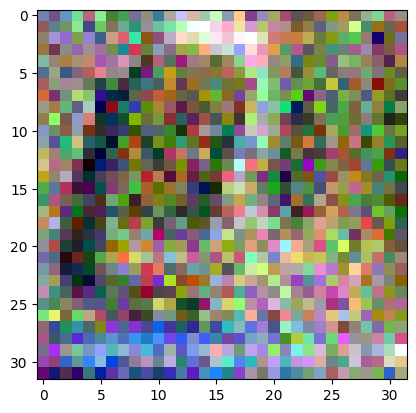

In [56]:
plt.imshow(x_train[5346].astype(int))

In [42]:
losses_proba = np.exp(losses_assessment)/sum(np.exp(losses_assessment))

In [43]:
results = {}

# test_models = ["test_model_1", "test_model_2", "test_model_3"]
test_models = ["test_model_1"]

In [50]:
for test_model in test_models:
    print(test_model)
    model_scores = []

    for _ in tqdm(range(N_TRIALS)):
        model = ClassifierModel(output_shape=10, **models_hyperparameters[test_model])
        
        model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
        
        last_best = 0
        n_same = 0
        for i in range(N_EPOCHS):
            n_samples = int(np.tanh(2 * (i + 1)/ (N_EPOCHS / 4)) * train_size)
            samples_ids = np.random.choice(range(train_size), p=losses_proba, size=n_samples, replace=False)
            
            history = model.fit(
                x_train[samples_ids], y_train[samples_ids], 
                validation_data=(x_val, y_val),
                epochs=1, batch_size=BATCH_SIZE, verbose=1,
            )
            
            n_same += 1
            if last_best < history.history["val_accuracy"][-1]:
                last_best = history.history["val_accuracy"][-1]
                n_same = 0
            
            if i >= 30 and n_same == 5:
                print(f"LAST EPOCH: {i}")
                break
        
        _, accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1)
        
        model_scores.append(accuracy)
    
    results[test_model] = model_scores

test_model_1


  0%|          | 0/3 [00:00<?, ?it/s]

27/27 [==============================] - 1s 32ms/step - loss: 1.4512 - accuracy: 0.4664 - val_loss: 1.4448 - val_accuracy: 0.4687
LAST EPOCH: 53
6/6 [==============================] - 0s 8ms/step - loss: 1.4737 - accuracy: 0.4573


 33%|███▎      | 1/3 [00:37<01:15, 37.57s/it]

27/27 [==============================] - 1s 32ms/step - loss: 1.4372 - accuracy: 0.4644 - val_loss: 1.4957 - val_accuracy: 0.4767
LAST EPOCH: 55
6/6 [==============================] - 0s 9ms/step - loss: 1.4695 - accuracy: 0.4533


 67%|██████▋   | 2/3 [01:21<00:41, 41.25s/it]

28/28 [==============================] - 1s 31ms/step - loss: 1.3956 - accuracy: 0.4855 - val_loss: 1.4849 - val_accuracy: 0.4780
LAST EPOCH: 63
6/6 [==============================] - 0s 8ms/step - loss: 1.4529 - accuracy: 0.4653


100%|██████████| 3/3 [02:11<00:00, 43.89s/it]


In [51]:
results

{'test_model_1': [0.4573333263397217, 0.4533333480358124, 0.46533334255218506]}

In [26]:
results

{'test_model_1': [0.49933332204818726, 0.4893333315849304, 0.4933333396911621]}

In [30]:
np.unique(samples_ids).shape

(6995,)

In [ ]:
{'test_model_1': [0.5386666655540466, 0.5506666898727417, 0.5633333325386047]}

In [107]:
(np.tanh(2 * (200 + 1)/ N_EPOCHS))

0.9647273193205547

In [112]:
(np.tanh(2 * (50 + 1)/ (N_EPOCHS / 2)))

0.7698665359089003